<a href="https://colab.research.google.com/github/mahimscit/DO180-apps/blob/master/research_agent_scrapegraph_langgraph_tavily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/drive/1lk4cjuRLDN0w71kXm9uAPQM6jH03yGW9?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Research Agent with `scrapegraph`, `langgraph`, and `tavily`

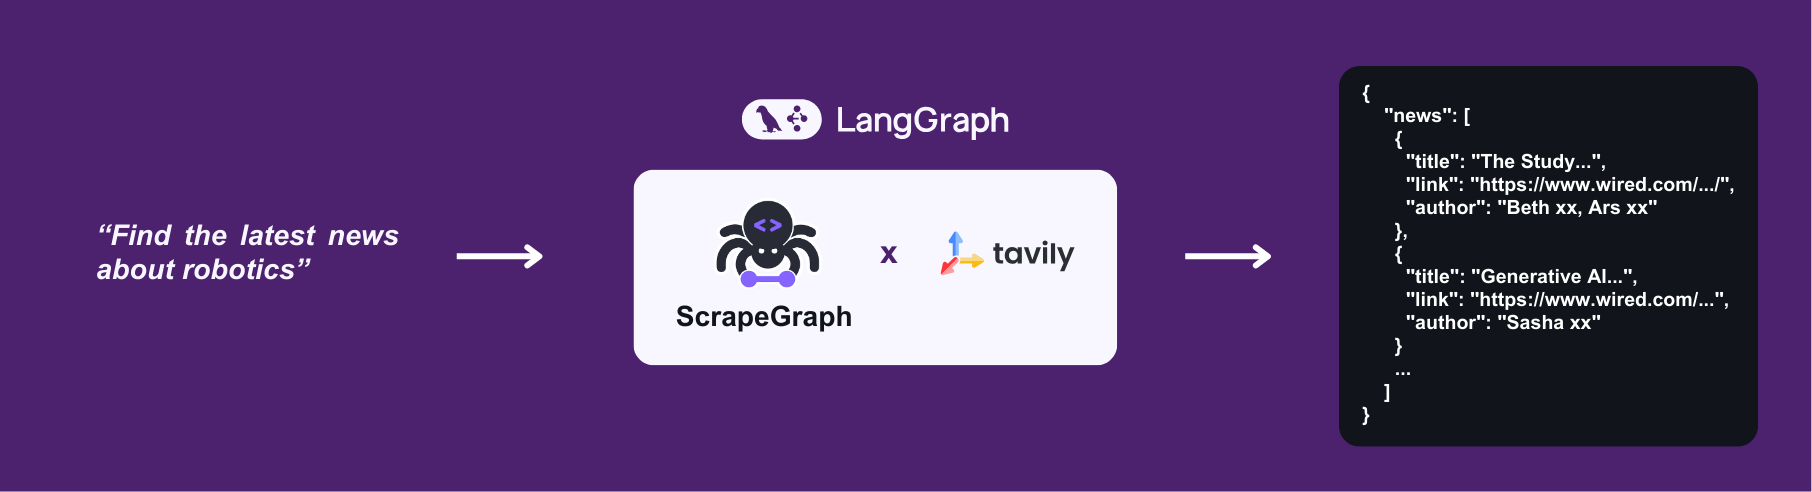

### 🔧 Install `dependencies`

In [ ]:
%%capture
!pip install langgraph langchain-scrapegraph langchain-openai "langchain-community>=0.2.11" tavily-python

### 🔑 Import `ScrapeGraph`, `Tavily` and `OpenAI` API keys

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [ ]:
import getpass
import os

if not os.environ.get("SGAI_API_KEY"):
    os.environ["SGAI_API_KEY"] = getpass.getpass("Scrapegraph API key:\n")

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:\n")

Scrapegraph API key:
··········
Tavily API key:
··········
OpenAI API key:
··········


### 📝 Defining an `Output Schema` for Webpage Content Extraction


If you already know what you want to extract from a webpage, you can **define an output schema** using **Pydantic**. This schema acts as a "blueprint" that tells the AI how to structure the response.

<details>
  <summary>Pydantic Schema Quick Guide</summary>

Types of Schemas  

1. Simple Schema  
Use this when you want to extract straightforward information, such as a single piece of content.  

```python
from pydantic import BaseModel, Field

# Simple schema for a single webpage
class PageInfoSchema(BaseModel):
    title: str = Field(description="The title of the webpage")
    description: str = Field(description="The description of the webpage")

# Example Output JSON after AI extraction
{
    "title": "ScrapeGraphAI: The Best Content Extraction Tool",
    "description": "ScrapeGraphAI provides powerful tools for structured content extraction from websites."
}
```

2. Complex Schema (Nested)  
If you need to extract structured information with multiple related items (like a list of repositories), you can **nest schemas**.

```python
from pydantic import BaseModel, Field
from typing import List

# Define a schema for a single repository
class RepositorySchema(BaseModel):
    name: str = Field(description="Name of the repository (e.g., 'owner/repo')")
    description: str = Field(description="Description of the repository")
    stars: int = Field(description="Star count of the repository")
    forks: int = Field(description="Fork count of the repository")
    today_stars: int = Field(description="Stars gained today")
    language: str = Field(description="Programming language used")

# Define a schema for a list of repositories
class ListRepositoriesSchema(BaseModel):
    repositories: List[RepositorySchema] = Field(description="List of GitHub trending repositories")

# Example Output JSON after AI extraction
{
    "repositories": [
        {
            "name": "google-gemini/cookbook",
            "description": "Examples and guides for using the Gemini API",
            "stars": 8036,
            "forks": 1001,
            "today_stars": 649,
            "language": "Jupyter Notebook"
        },
        {
            "name": "TEN-framework/TEN-Agent",
            "description": "TEN Agent is a conversational AI powered by TEN, integrating Gemini 2.0 Multimodal Live API, OpenAI Realtime API, RTC, and more.",
            "stars": 3224,
            "forks": 311,
            "today_stars": 361,
            "language": "Python"
        }
    ]
}
```

Key Takeaways  
- **Simple Schema**: Perfect for small, straightforward extractions.  
- **Complex Schema**: Use nesting to extract lists or structured data, like "a list of repositories."  

Both approaches give the AI a clear structure to follow, ensuring that the extracted content matches exactly what you need.
</details>


In [ ]:
from pydantic import BaseModel, Field
from typing import List

# Schema for a single news item
class NewsItemSchema(BaseModel):
    title: str = Field(description="Title of the news article")
    link: str = Field(description="URL to the news article")
    description: str = Field(description="Summary/description of the news article")

# Schema that contains a list of news items
class ListNewsSchema(BaseModel):
    news: List[NewsItemSchema] = Field(description="List of news articles with their details")

### 🚀 Initialize `scrapegraph` and `tavily` tools and `langgraph` prebuilt agent and run the `extraction`

Here we use `SmartScraperTool` to extract structured data using AI from a webpage.


> If you already have an HTML file, you can upload it and use `LocalScraperTool` instead.

You can find more info in the [official langchain documentation](https://python.langchain.com/docs/integrations/tools/scrapegraph/)



In [ ]:
from langchain_scrapegraph.tools import SmartScraperTool
from langchain_community.tools import TavilySearchResults

# Will automatically get SGAI_API_KEY from environment
# Initialization without output schema
# smartscraper_tool = SmartScraperTool()

# Since we have defined an output schema, let's use it
# This will force the tool to have always the same output structure
smartscraper_tool = SmartScraperTool(llm_output_schema=ListNewsSchema)

# Initialize tavily tool to look for URLs
tavily_tool = TavilySearchResults(
    max_results=1,
    name="urls_finder",
    description="Use this tool to find webpages urls that satisfy the user request",
)



We then initialize the `llm model` we want to use in the agent



In [ ]:
# First we initialize the llm model we want to use.
from langchain_openai import ChatOpenAI

llm_model = ChatOpenAI(model="gpt-4o", temperature=0)

Here we use `create_react_agent` to quickly use one of the prebuilt agents from `langgraph.prebuilt` module

You can find more info in the [official langgraph documentation](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/)



In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# List of tools we want the agent to use
tools = [smartscraper_tool, tavily_tool]

# We set up the agent's memory to review the different reasoning steps
memory = MemorySaver()

# Add a configuration to specify where to store the graph states
config = {"configurable": {"thread_id": "1"}}

# Initialize the ReAct agent
graph = create_react_agent(
    model=llm_model,
    tools=tools,
    checkpointer=memory,
)

Let's visualize the `graph`

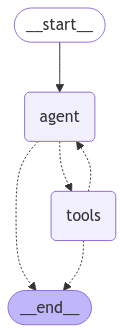

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

`Run the graph` and stream the agent reasoning.

We are going to ask the agent to extract the content from a `specific webpage`.

In [ ]:
# Inputs for the agent
inputs = {"messages": [("user", "Find latest news related to robotics December 2024")]}

# Run the graph
for event in graph.stream(inputs, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Find latest news related to robotics December 2024
================================== Ai Message ==================================
Tool Calls:
  urls_finder (call_MpBC8kxJoRPFaBEoXLmSZ4RX)
 Call ID: call_MpBC8kxJoRPFaBEoXLmSZ4RX
  Args:
    query: latest robotics news December 2024
================================= Tool Message =================================
Name: urls_finder

[{"url": "https://www.therobotreport.com/category/news/", "content": "The Robot Report Podcast reflects on the successes and challenges that defined the robotics industry in 2024. By The Robot Report Staff | December 19, ... Sanctuary AI showed its latest breakthrough with hydraulic actuation and precise in-hand manipulation to open up a range of high-value tasks. ... December 17, 2024. Slip Robotics picks up"}]
================================== Ai Message ==================================
Tool Calls:
  SmartScraper (call_enar

In [ ]:
# get last message (assuming the last one is the Smartscraper tool response)
result = graph.get_state(config).values["messages"][-1].content

import json
# convert string into json
result = json.loads(result)

Print the response

In [ ]:
print(json.dumps(result, indent=2))

{
  "news": [
    {
      "title": "Matternet adds ANRA's UTM tech to expand drone delivery",
      "link": "https://www.therobotreport.com/matternet-adds-anras-utm-tech-to-expand-drone-delivery/",
      "description": "This latest partnership follows Matternet\u2019s recent launch of a drone delivery operation in Silicon Valley."
    },
    {
      "title": "Helm.ai upgrades generative AI model to enrich autonomous driving data",
      "link": "https://www.therobotreport.com/helm-ai-upgrades-generative-ai-model-to-enrich-autonomous-driving-data/",
      "description": "Helm.ai said the new model enables automakers to generate diverse, realistic video data tailored to specific requirements."
    },
    {
      "title": "New research analyzes safety of Waymo robotaxis",
      "link": "https://www.therobotreport.com/new-research-analyzes-safety-of-waymo-robotaxis/",
      "description": "Waymo shared research with Swiss Re, one of the world\u2019s largest insurance providers, analyzing l

### 💾 Save the output to a `CSV` file

Let's create a pandas dataframe and show the table with the extracted content

In [ ]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(result["news"])
df

,title,link,description
0,Matternet adds ANRA's UTM tech to expand drone...,https://www.therobotreport.com/matternet-adds-...,This latest partnership follows Matternet’s re...
1,Helm.ai upgrades generative AI model to enrich...,https://www.therobotreport.com/helm-ai-upgrade...,Helm.ai said the new model enables automakers ...
2,New research analyzes safety of Waymo robotaxis,https://www.therobotreport.com/new-research-an...,"Waymo shared research with Swiss Re, one of th..."
3,From AI to humanoids: top robotics trends of 2024,https://www.therobotreport.com/from-ai-to-huma...,The Robot Report Podcast reflects on the succe...
4,"Symbotic acquires OhmniLabs, maker of disinfec...",https://www.therobotreport.com/symbotic-buys-h...,"With the acquisition of OhmniLabs, Symbotic sa..."
5,Sanctuary AI shows new dexterity with in-hand ...,https://www.therobotreport.com/sanctuary-ai-sh...,Sanctuary AI showed its latest breakthrough wi...
6,Apptronik partners with Google DeepMind to adv...,https://www.therobotreport.com/apptronik-partn...,Apptronik will combine its iterative design ex...
7,"Alimak Group, Skyline Robotics create autonomo...",https://www.therobotreport.com/alimak-group-sk...,Skyline Robotics said the joint system can hel...
8,DoorDash partners with Wing to launch drone de...,https://www.therobotreport.com/doordash-partne...,"Beginning today, when certain DoorDash custome..."
9,Mcity says open-source digital twin enables ch...,https://www.therobotreport.com/mcity-open-sour...,The Mcity test facility has been open since 20...


Save it to CSV

In [ ]:
# Save the DataFrame to a CSV file
csv_file = "news.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to news.csv


## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  
- 🦜 **Langchain:** [ScrapeGraph docs](https://python.langchain.com/docs/integrations/tools/scrapegraph/)

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
